# Useful Links

* Pytorch model: https://pytorch.org/vision/stable/models/generated/torchvision.models.googlenet.html#torchvision.models.googlenet
*   https://pytorch.org/hub/pytorch_vision_googlenet/
*   Background info: https://cs231n.github.io/transfer-learning/
*   https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* Finetuning: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html




In [8]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import shutil
import time
import copy

### Loading in Data

#### Splitting up Data into train-val-test folders (DO NOT RUN)

In [10]:
# Splitting data
# Data Loading and Splitting

train_files_list = []
val_files_list = []
test_files_list = []
files_list = []

dataset_size = 7983
split = [0.7,0.2,0.1]

train_size = int(split[0]*dataset_size)
val_size = int(split[1]*dataset_size)
test_size = dataset_size - (train_size + val_size)
print("Train size:",train_size,"\nVal size:",val_size,"\nTest size:",test_size)

# Fixed PyTorch random seed for reproducible result
np.random.seed(1000)

indices = list(range(0,dataset_size))
train_indices = list(np.random.choice(indices, train_size, replace=False))
other_than_train_indices = list(set(indices) - set(train_indices))
val_indices = np.random.choice(other_than_train_indices, val_size, replace=False)
test_indices = list(set(other_than_train_indices)-set(val_indices))

old_path = "/content/drive/MyDrive/APS360 Project - Initial Dataset (1)"

for root, dirs, files in os.walk(old_path):
    for file in files:
        #all 
        
        if file.endswith(".png"):
            files_list.append(os.path.join(root, file))

#print images
#lets me count and print the amount of jpeg,jpg,pmg 
file_count = len(files_list)
print("We have:",file_count,"images")
 
split_files_list = [ [files_list[i] for i in train_indices], [files_list[i] for i in val_indices], [files_list[i] for i in test_indices] ]

destPaths = ['train','val','test']
root_path = "/content/drive/MyDrive/train_val_test_split"

for i in range(len(destPaths)):

  destPath = os.path.join(root_path,destPaths[i])
  # if destination dir does not exists, create it
  if os.path.isdir(destPath) == False:
          os.makedirs(destPath)

  # iterate over all random files and move them
  for file in split_files_list[i]:

    file_class = (file.split('/'))[-2]
    classPath = os.path.join(destPath,file_class)
    if os.path.isdir(classPath) == False:
          os.makedirs(classPath)

    # shutil.copy(file, classPath)

Train size: 5588 
Val size: 1596 
Test size: 799


#### Transforms

In [11]:
# Image preprocessing for INCEPTION V3

#preprocess = models.GoogLeNet_Weights.IMAGENET1K_V1.transforms
#preprocess = model.Inception_V3_Weights.IMAGENET1K_V1.transforms
# INCEPTION ---------------------------

# Data augmentation and normalization for training
# Just normalization for validation
input_size = 299
input_resize = 342

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(input_resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

#### Datasets and Dataloaders

In [12]:
# Loading in Data
batch_size = 64
root_path = "/content/drive/MyDrive/train_val_test_split"
# Fixed PyTorch random seed for reproducible result
torch.manual_seed(1000)

# Create training and validation and test datasets
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(root_path, x), 
                                                      data_transforms[x]) for x in ['train', 'val','test']}

classes = image_datasets['train'].classes
num_classes = len(classes)
print("Number of classes:",num_classes)

# Create training and validation and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, 
                                                   shuffle=True, num_workers=1) for x in ['train', 'val','test']}


Number of classes: 80


### Visualizing sample data

Images size: torch.Size([64, 3, 299, 299])
Labels size: tensor([27, 24, 58, 13, 62, 16, 19, 77, 35, 39, 46,  7, 38, 21, 53,  8, 73, 41,
        32, 75, 66, 35, 32, 32, 30, 43, 67,  7,  6, 27, 32, 39, 75, 44, 28, 58,
        47, 27, 21,  5, 68,  1, 68, 71, 11, 78, 55, 76, 59, 16, 31,  7, 36, 28,
        14,  1, 23, 66, 70, 42, 74, 23, 42, 60])


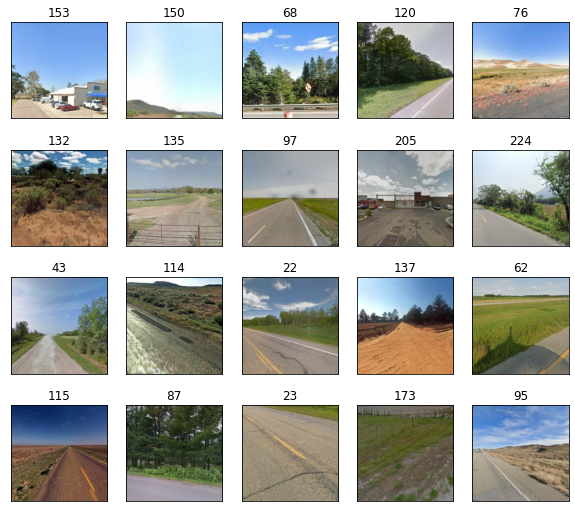

In [16]:
# Visualize some sample data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp[0].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# # obtain one batch of training images
images, labels = next(iter(dataloaders_dict['train']))
print("Images size:",images.shape)
print("Labels size:",labels.data)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 9))
for i in np.arange(20):
    ax = fig.add_subplot(4, 20/4, i+1, xticks=[], yticks=[])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = images[i].numpy().transpose((1,2,0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    ax.set_title(classes[labels[i]])

## Model

### Initializing InceptionV3

In [6]:
incepNet = models.inception_v3(weights='Inception_V3_Weights.IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [11]:

# Freezing all the gradients of the model parameters (TRANSFER LEARNING)
for param in incepNet.parameters():
    param.requires_grad = False

# Changing the number of output features for the FC linear classifiers to 
# match the number of classes (80)

# Auxiliary Loss FC layer
num_aux_ftrs = incepNet.AuxLogits.fc.in_features
print("Auxliary loss features:",num_aux_ftrs)
incepNet.AuxLogits.fc = nn.Linear(num_aux_ftrs, num_classes)

# Final Loss FC layer
num_ftrs = incepNet.fc.in_features
print("Final loss features:",num_ftrs)
incepNet.fc = nn.Linear(num_ftrs,num_classes)

# Choosing which parameter gradients to optimize (only at the final FC layers)
print("Params to learn:")

params_to_update = []
for name,param in incepNet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)


Auxliary loss features: 768
Final loss features: 2048
Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


### Training the Model

In [20]:
def init_model():
  incepNet = models.inception_v3(weights='Inception_V3_Weights.IMAGENET1K_V1')
  # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
  for param in incepNet.parameters():
      param.requires_grad = False

  # Changing the number of output features for the FC linear classifiers to 
  # match the number of classes (80)
  # Auxiliary Loss FC layer
  num_aux_ftrs = incepNet.AuxLogits.fc.in_features
  incepNet.AuxLogits.fc = nn.Linear(num_aux_ftrs, num_classes)

  # Final Loss FC layer
  num_ftrs = incepNet.fc.in_features
  incepNet.fc = nn.Linear(num_ftrs,num_classes)

  # Choosing which parameter gradients to optimize (only at the final FC layers)
  params_to_update = []
  for name,param in incepNet.named_parameters():
      if param.requires_grad == True:
          params_to_update.append(param)
  return incepNet, params_to_update

In [33]:
# Training code modified from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def train_model(model, datasets, batch_size=64, learning_rate=1e-3, aux_coef=0.4, num_epochs=5):
    since = time.time()

    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], 
                                                  batch_size=batch_size, 
                                                  shuffle=True, 
                                                  num_workers=1) for x in ['train', 'val']}

    # Observe that some parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=learning_rate)
    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    val_loss_history = []
    val_acc_history = []
    train_loss_history = []
    train_acc_history = []
    epochs = np.arange(0,num_epochs)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                #############################################
                #To Enable GPU Usage
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()
                  labels = labels.cuda()
                #############################################

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for the loss by summing the final output and the auxiliary output
                    #   but in testing inception because in training it has an auxiliary output. In train
                    #   mode we calculate  only consider the final output.
                    if phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + aux_coef*loss2

                    # _, preds = torch.max(outputs, 1)
                    preds = outputs.max(1, keepdim=True)[1]

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += preds.eq(labels.view_as(preds)).sum().item()
                print('{} Running Loss: {:.4f} Running Acc: {:.4f}'.format(phase, running_loss, running_corrects))
                # running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = float(running_corrects) / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_history.append(epoch_loss)

        # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    plt.title("Training vs Validation Loss Curve")
    plt.plot(epochs, train_loss_history, label="Train")
    plt.plot(epochs, val_loss_history, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training vs Validation Accuracy Curve")
    plt.plot(epochs, train_acc_history, label="Train")
    plt.plot(epochs, val_acc_history, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [34]:
def test_model(model, datasets, batch_size=64, learning_rate=1e-3, aux_coef=0.4, num_epochs=5):
    since = time.time()

    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], 
                                                  batch_size=batch_size, 
                                                  shuffle=True, 
                                                  num_workers=1) for x in ['test']}

    # Observe that some parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=learning_rate)
    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    test_loss_history = []
    test_acc_history = []
    epochs = np.arange(0,num_epochs)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['test']:
            if phase == 'test':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                #############################################
                #To Enable GPU Usage
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()
                  labels = labels.cuda()
                #############################################

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'test'):
                    # Get model outputs and calculate loss
                    # Special case for the loss by summing the final output and the auxiliary output
                    #   but in testing inception because in training it has an auxiliary output. In train
                    #   mode we calculate  only consider the final output.
                    if phase == 'test':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + aux_coef*loss2

                    # _, preds = torch.max(outputs, 1)
                    preds = outputs.max(1, keepdim=True)[1]

                    # backward + optimize only if in training phase
                    if phase == 'test':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += preds.eq(labels.view_as(preds)).sum().item()
                print('{} Running Loss: {:.4f} Running Acc: {:.4f}'.format(phase, running_loss, running_corrects))
                # running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = float(running_corrects) / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test':
              test_acc_history.append(epoch_acc)
              test_loss_history.append(epoch_loss)

        # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    plt.title("Training Loss Curve")
    plt.plot(epochs, test_loss_history, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Accuracy Curve")
    plt.plot(epochs, test_acc_history, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.show()

    return

CUDA is available!  Training on GPU ...
Epoch 0/29
----------
test Running Loss: 1610.1147 Running Acc: 1.0000
test Running Loss: 3218.9486 Running Acc: 3.0000
test Running Loss: 4821.0750 Running Acc: 5.0000
test Running Loss: 5013.9468 Running Acc: 6.0000
test Loss: 6.2753 Acc: 0.0075
Epoch 1/29
----------
test Running Loss: 1521.7051 Running Acc: 7.0000
test Running Loss: 3040.6281 Running Acc: 17.0000
test Running Loss: 4559.8759 Running Acc: 23.0000
test Running Loss: 4744.0109 Running Acc: 24.0000
test Loss: 5.9374 Acc: 0.0300
Epoch 2/29
----------
test Running Loss: 1472.5691 Running Acc: 14.0000
test Running Loss: 2934.1497 Running Acc: 23.0000
test Running Loss: 4400.3094 Running Acc: 29.0000
test Running Loss: 4588.4084 Running Acc: 29.0000
test Loss: 5.7427 Acc: 0.0363
Epoch 3/29
----------
test Running Loss: 1408.4709 Running Acc: 18.0000
test Running Loss: 2819.5801 Running Acc: 45.0000
test Running Loss: 4225.3831 Running Acc: 66.0000
test Running Loss: 4393.0648 Running 

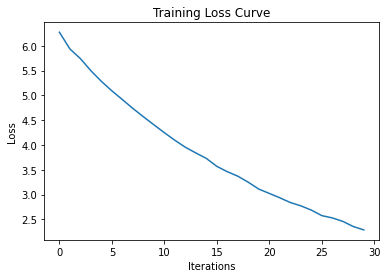

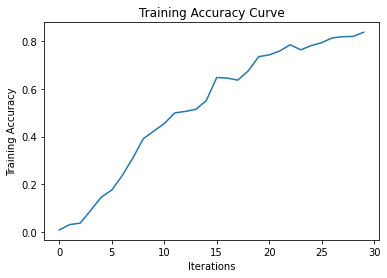

In [35]:
use_cuda = True
model, params_to_update = init_model()

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

test_model(model, datasets=image_datasets, batch_size=256, learning_rate=1e-3, aux_coef=0.4, num_epochs=30)

CUDA is available!  Training on GPU ...
Epoch 0/99
----------
test Running Loss: 1589.3665 Running Acc: 3.0000
test Running Loss: 3183.9863 Running Acc: 6.0000
test Running Loss: 4796.6870 Running Acc: 9.0000
test Running Loss: 4994.9287 Running Acc: 9.0000
test Loss: 6.2515 Acc: 0.0113
Epoch 1/99
----------
test Running Loss: 1508.5918 Running Acc: 11.0000
test Running Loss: 3013.4714 Running Acc: 16.0000
test Running Loss: 4533.3798 Running Acc: 19.0000
test Running Loss: 4717.4067 Running Acc: 19.0000
test Loss: 5.9041 Acc: 0.0238
Epoch 2/99
----------
test Running Loss: 1454.4290 Running Acc: 23.0000
test Running Loss: 2923.3306 Running Acc: 42.0000
test Running Loss: 4392.9286 Running Acc: 51.0000
test Running Loss: 4569.2199 Running Acc: 51.0000
test Loss: 5.7187 Acc: 0.0638
Epoch 3/99
----------
test Running Loss: 1416.6405 Running Acc: 25.0000
test Running Loss: 2812.5770 Running Acc: 47.0000
test Running Loss: 4201.9113 Running Acc: 74.0000
test Running Loss: 4371.9422 Running

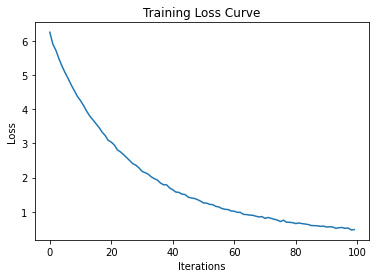

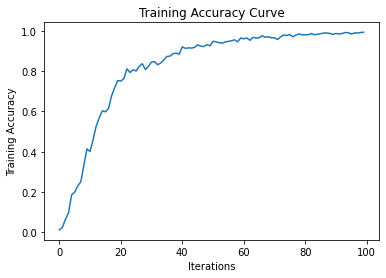

In [36]:
model, params_to_update = init_model()

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

test_model(model, datasets=image_datasets, batch_size=256, learning_rate=1e-3, aux_coef=0.4, num_epochs=100)